In [110]:
import face_recognition
from face_recognition import face_locations
import os
import pandas as pd
import h5py
from tqdm import tqdm
from recursive_dict import *
import scipy.io
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split


In [17]:
# set data paths
data_dir = '/Users/arthur/Desktop/2022 EM/Machine Learning/Projet/Data/LWFA+'
img_dir = os.path.join(data_dir, 'lfw/merge_folder')
indices_path = os.path.join(data_dir, 'indices_train_test.mat')
attr_path = os.path.join(data_dir, 'lfw_att_73.mat')

In [70]:
label_mat = '/Users/arthur/Desktop/2022 EM/Machine Learning/Projet/Data/LWFA+/label.mat'
label = scipy.io.loadmat(label_mat)['label']

name_mat = '/Users/arthur/Desktop/2022 EM/Machine Learning/Projet/Data/LWFA+/name.mat'
name = scipy.io.loadmat(name_mat)['name']
name = [s[0].split('\\')[1] for s in name.tolist()[0]]

attr_name_mat = '/Users/arthur/Desktop/2022 EM/Machine Learning/Projet/Data/LWFA+/attrname.mat'
attr_name = scipy.io.loadmat(attr_name_mat)['AttrName']
attr_name = [str(s[0]) for s in attr_name.tolist()[0]]

In [71]:
df_label = pd.DataFrame(label, columns=attr_name, index=name)

In [74]:
df_label

,Male,Asian,White,Black,Baby,Child,Youth,Middle Aged,Senior,Black Hair,...,Pale Skin,5 o Clock Shadow,Strong Nose-Mouth Lines,Wearing Lipstick,Flushed Face,High Cheekbones,Brown Eyes,Wearing Earrings,Wearing Necktie,Wearing Necklace
Aaron_Eckhart_0001.jpg,1,0,1,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,1,0
Aaron_Guiel_0001.jpg,1,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
Aaron_Patterson_0001.jpg,1,0,0,0,0,0,0,1,0,0,...,1,1,0,0,0,0,1,0,1,0
Aaron_Peirsol_0001.jpg,1,0,1,0,0,0,1,1,0,0,...,1,0,1,0,0,1,1,0,1,0
Aaron_Peirsol_0002.jpg,1,0,1,0,0,0,1,1,0,0,...,0,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zorica_Radovic_0001.jpg,0,0,0,0,0,1,0,0,0,1,...,0,0,0,1,0,0,1,0,0,0
Zulfiqar_Ahmed_0001.jpg,1,0,0,0,0,0,0,1,0,1,...,0,1,0,0,0,0,1,0,1,0
Zumrati_Juma_0001.jpg,0,0,1,1,0,0,0,0,1,0,...,0,0,1,0,0,1,1,0,0,0
Zurab_Tsereteli_0001.jpg,1,0,1,0,0,0,0,0,1,0,...,0,0,1,0,0,1,1,0,1,0


In [73]:
df_label.index

Index(['Aaron_Eckhart_0001.jpg', 'Aaron_Guiel_0001.jpg',
       'Aaron_Patterson_0001.jpg', 'Aaron_Peirsol_0001.jpg',
       'Aaron_Peirsol_0002.jpg', 'Aaron_Peirsol_0003.jpg',
       'Aaron_Peirsol_0004.jpg', 'Aaron_Pena_0001.jpg',
       'Aaron_Sorkin_0001.jpg', 'Aaron_Sorkin_0002.jpg',
       ...
       'Zoe_Ball_0001.jpg', 'Zoran_Djindjic_0001.jpg',
       'Zoran_Djindjic_0002.jpg', 'Zoran_Djindjic_0003.jpg',
       'Zoran_Djindjic_0004.jpg', 'Zorica_Radovic_0001.jpg',
       'Zulfiqar_Ahmed_0001.jpg', 'Zumrati_Juma_0001.jpg',
       'Zurab_Tsereteli_0001.jpg', 'Zydrunas_Ilgauskas_0001.jpg'],
      dtype='object', length=13143)

In [77]:
# extract face features using face_recognition.face_encodings
# take about 10 minutes on my pc
feature_vecs = []
fnames = []
for fname in tqdm(df_label.index):
    img_path = os.path.join(img_dir, fname)
    # face detection
    X_img = face_recognition.load_image_file(img_path)
    X_faces_loc = face_locations(X_img)
    # if the number of faces detected in a image is not 1, ignore the image
    if len(X_faces_loc) != 1:
        continue
    # extract 128 dimensional face features
    faces_encoding = face_recognition.face_encodings(X_img, known_face_locations=X_faces_loc)[0]
    feature_vecs.append(faces_encoding)
    fnames.append(fname)
df_feat = pd.DataFrame(feature_vecs, index=fnames)
df_label = df_label[df_label.index.isin(df_feat.index)]
df_feat.sort_index(inplace=True)
df_label.sort_index(inplace=True)

df_feat.to_csv('feature.csv')
df_label.to_csv('label.csv')


100%|██████████████████████████████████████████████████████████████| 12264/12264 [07:41<00:00, 26.60it/s]


In [82]:
# load features and labels
df_feat = pd.read_csv('feature.csv', index_col=0)
df_label = pd.read_csv('label.csv', index_col=0)

In [83]:
# split training/test name
unique_names = list(set([path.split('/')[0] for path in df_feat.index]))
name_train, name_test = train_test_split(unique_names, test_size = 0.1, random_state = 0)
name_train, name_test = set(name_train), set(name_test)
# split training/test images
idx_train = [path.split('/')[0] in name_train for path in df_feat.index]
idx_test = [path.split('/')[0] in name_test for path in df_feat.index]
X_train, Y_train = df_feat[idx_train], df_label[idx_train]
X_test, Y_test = df_feat[idx_test], df_label[idx_test]

In [90]:
X_test

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
Aaron_Patterson_0001.jpg,-0.068305,0.137371,0.105704,0.007556,-0.054209,-0.043051,0.055275,-0.129689,0.207762,-0.047512,...,-0.031420,0.030030,0.018635,-0.105226,-0.129384,-0.081238,0.024817,0.011313,-0.065541,0.025581
Aaron_Peirsol_0003.jpg,-0.161475,0.072072,0.026793,-0.041169,-0.215200,-0.031179,0.012535,-0.099728,0.059607,-0.005566,...,0.118397,0.036842,-0.002636,0.001037,-0.122123,-0.159075,-0.016821,-0.092484,0.019967,0.060692
Aaron_Pena_0001.jpg,-0.066269,0.047924,0.068584,0.019470,-0.030645,-0.008207,-0.044521,-0.085837,0.145594,-0.011958,...,0.051948,0.025356,-0.032264,-0.020647,-0.085189,-0.096633,0.047282,-0.064004,0.060172,0.007854
Abdullah_Gul_0001.jpg,-0.017071,-0.038122,0.028934,-0.052990,-0.020648,-0.100689,0.015402,-0.054737,0.079822,-0.059748,...,0.053631,-0.017035,0.027640,0.050348,-0.149704,-0.126687,0.033771,0.053065,0.012058,-0.001230
Abdullah_Gul_0011.jpg,-0.081393,0.008890,0.033298,-0.035668,-0.038170,-0.099961,0.023551,-0.110557,0.091811,-0.049337,...,-0.007993,0.048489,-0.013780,0.010315,-0.071384,-0.113932,0.017602,0.027732,-0.008859,-0.044646
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zhu_Rongji_0003.jpg,-0.064241,0.082620,0.010610,0.039137,-0.097494,-0.095973,-0.014834,-0.142342,0.106692,-0.069932,...,0.107530,0.095409,-0.004340,0.006496,-0.155327,-0.099411,0.070643,0.069341,0.087765,-0.030006
Zico_0003.jpg,-0.037489,0.138485,0.074554,-0.057432,-0.192327,0.094849,-0.074912,-0.102558,0.095749,-0.048314,...,0.128406,0.089886,0.029889,0.072995,-0.138140,-0.160222,0.009887,-0.125427,-0.052566,0.099514
Zinedine_Zidane_0004.jpg,-0.121535,0.156134,0.039400,-0.053500,-0.142789,-0.028853,-0.031799,-0.111320,0.086823,0.063615,...,0.117592,0.029921,0.015491,0.055531,0.004904,-0.090824,-0.000132,-0.080918,-0.015574,-0.005016
Zulfiqar_Ahmed_0001.jpg,-0.119783,0.076151,0.059952,-0.013495,-0.089752,0.048293,-0.012967,-0.089518,0.231281,-0.116879,...,0.057306,0.017699,0.022172,0.046752,-0.121938,-0.126211,-0.026085,-0.068005,0.108207,0.070668


In [96]:
clf = MLPClassifier(solver='adam', hidden_layer_sizes=(128, 128),max_iter = 5000, verbose=True, tol=1e-4, activation='relu')
clf.fit(X_train, Y_train)
prediction = clf.predict(X_test)
prediction_score = clf.predict_proba(X_test)

df_prediction = pd.DataFrame(prediction, columns=df_label.columns, index=Y_test.index)
df_prediction_score = pd.DataFrame(prediction_score, columns=df_label.columns, index=Y_test.index)

Iteration 1, loss = 40.36527588
Iteration 2, loss = 34.64513750
Iteration 3, loss = 32.78425638
Iteration 4, loss = 31.92068587
Iteration 5, loss = 31.29759227
Iteration 6, loss = 30.88921763
Iteration 7, loss = 30.62021637
Iteration 8, loss = 30.39363537
Iteration 9, loss = 30.19147866
Iteration 10, loss = 30.01221662
Iteration 11, loss = 29.84623389
Iteration 12, loss = 29.72655520
Iteration 13, loss = 29.59777721
Iteration 14, loss = 29.49170208
Iteration 15, loss = 29.38578416
Iteration 16, loss = 29.28492891
Iteration 17, loss = 29.20313870
Iteration 18, loss = 29.12233712
Iteration 19, loss = 29.06061264
Iteration 20, loss = 29.00080026
Iteration 21, loss = 28.94616553
Iteration 22, loss = 28.88299067
Iteration 23, loss = 28.82945928
Iteration 24, loss = 28.78110691
Iteration 25, loss = 28.72643461
Iteration 26, loss = 28.68864512
Iteration 27, loss = 28.65581183
Iteration 28, loss = 28.62747527
Iteration 29, loss = 28.57907348
Iteration 30, loss = 28.54470568
Iteration 31, loss 

Iteration 246, loss = 25.70257040
Iteration 247, loss = 25.68632800
Iteration 248, loss = 25.71293676
Iteration 249, loss = 25.72002674
Iteration 250, loss = 25.66566758
Iteration 251, loss = 25.66181871
Iteration 252, loss = 25.65594587
Iteration 253, loss = 25.67052321
Iteration 254, loss = 25.66736971
Iteration 255, loss = 25.62855011
Iteration 256, loss = 25.61416853
Iteration 257, loss = 25.61322620
Iteration 258, loss = 25.66528648
Iteration 259, loss = 25.64540876
Iteration 260, loss = 25.59805705
Iteration 261, loss = 25.59867701
Iteration 262, loss = 25.60864876
Iteration 263, loss = 25.61209221
Iteration 264, loss = 25.58723347
Iteration 265, loss = 25.55842969
Iteration 266, loss = 25.55857864
Iteration 267, loss = 25.56874156
Iteration 268, loss = 25.58547919
Iteration 269, loss = 25.54713899
Iteration 270, loss = 25.55403645
Iteration 271, loss = 25.53457024
Iteration 272, loss = 25.51845817
Iteration 273, loss = 25.49505575
Iteration 274, loss = 25.52242308
Iteration 275,

Iteration 487, loss = 24.56301966
Iteration 488, loss = 24.56372527
Iteration 489, loss = 24.53086991
Iteration 490, loss = 24.53793245
Iteration 491, loss = 24.55831839
Iteration 492, loss = 24.54012910
Iteration 493, loss = 24.54014279
Iteration 494, loss = 24.51793154
Iteration 495, loss = 24.55177424
Iteration 496, loss = 24.52107543
Iteration 497, loss = 24.49290024
Iteration 498, loss = 24.50065644
Iteration 499, loss = 24.50449817
Iteration 500, loss = 24.56443771
Iteration 501, loss = 24.52101933
Iteration 502, loss = 24.52875530
Iteration 503, loss = 24.50003356
Iteration 504, loss = 24.48607215
Iteration 505, loss = 24.51212093
Iteration 506, loss = 24.61273875
Iteration 507, loss = 24.51967309
Iteration 508, loss = 24.50217906
Iteration 509, loss = 24.47687842
Iteration 510, loss = 24.46743268
Iteration 511, loss = 24.47719926
Iteration 512, loss = 24.47306784
Iteration 513, loss = 24.47529478
Iteration 514, loss = 24.46255365
Iteration 515, loss = 24.43499035
Iteration 516,

In [92]:
print(pred)

[[1 0 0 ... 0 1 0]
 [1 0 1 ... 0 0 0]
 [1 0 1 ... 0 1 1]
 ...
 [1 0 1 ... 0 1 0]
 [1 0 0 ... 0 0 0]
 [1 0 1 ... 0 1 0]]


In [93]:
print(score)

[[9.97271856e-01 2.71048894e-02 4.73561024e-02 ... 4.45271590e-04
  8.57520400e-01 3.08263683e-03]
 [9.28354495e-01 1.54412302e-02 9.63916452e-01 ... 8.16508501e-03
  4.41560866e-01 8.63087013e-02]
 [9.59661541e-01 1.68990606e-03 8.88831543e-01 ... 6.97842995e-02
  6.61224537e-01 5.40176334e-01]
 ...
 [9.96305380e-01 3.00448880e-02 9.76764935e-01 ... 1.45419557e-03
  9.20489699e-01 2.02306995e-02]
 [9.57169993e-01 1.62291161e-03 3.38956848e-01 ... 1.02117925e-02
  4.28094508e-01 9.55706457e-02]
 [9.16049125e-01 7.89493786e-03 9.13605737e-01 ... 7.00383213e-03
  8.82601634e-01 9.94553915e-02]]


In [94]:
df_pred

,Male,Asian,White,Black,Baby,Child,Youth,Middle Aged,Senior,Black Hair,...,Pale Skin,5 o Clock Shadow,Strong Nose-Mouth Lines,Wearing Lipstick,Flushed Face,High Cheekbones,Brown Eyes,Wearing Earrings,Wearing Necktie,Wearing Necklace
Aaron_Patterson_0001.jpg,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,1,0
Aaron_Peirsol_0003.jpg,1,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
Aaron_Pena_0001.jpg,1,0,1,0,0,0,0,0,0,0,...,1,1,1,0,0,1,1,0,1,1
Abdullah_Gul_0001.jpg,1,0,1,0,0,0,0,0,0,0,...,0,1,1,0,0,0,1,0,1,0
Abdullah_Gul_0011.jpg,1,0,0,0,0,0,0,1,0,0,...,0,1,1,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zhu_Rongji_0003.jpg,1,1,0,0,0,0,0,0,1,0,...,1,0,1,0,0,1,1,0,1,0
Zico_0003.jpg,1,0,1,0,0,0,0,0,0,0,...,1,1,0,0,0,0,1,0,1,0
Zinedine_Zidane_0004.jpg,1,0,1,0,0,0,0,0,0,0,...,1,1,0,0,0,0,1,0,1,0
Zulfiqar_Ahmed_0001.jpg,1,0,0,0,0,0,0,0,0,1,...,0,1,1,0,0,0,1,0,0,0


In [100]:
pd.set_option("display.max_rows", 999)
df_score

,Male,Asian,White,Black,Baby,Child,Youth,Middle Aged,Senior,Black Hair,...,Pale Skin,5 o Clock Shadow,Strong Nose-Mouth Lines,Wearing Lipstick,Flushed Face,High Cheekbones,Brown Eyes,Wearing Earrings,Wearing Necktie,Wearing Necklace
Aaron_Patterson_0001.jpg,0.997272,0.027105,0.047356,0.037332,0.003452,0.012842,0.018265,0.439263,0.004919,0.202241,...,0.322340,0.984735,0.076826,0.001268,0.022805,0.007809,0.976353,0.000445,0.857520,0.003083
Aaron_Peirsol_0003.jpg,0.928354,0.015441,0.963916,0.001644,0.000944,0.020841,0.664743,0.058775,0.011981,0.056582,...,0.498698,0.359955,0.281961,0.014938,0.145452,0.425775,0.578820,0.008165,0.441561,0.086309
Aaron_Pena_0001.jpg,0.959662,0.001690,0.888832,0.001549,0.000039,0.003405,0.240427,0.413858,0.016687,0.318419,...,0.602108,0.558745,0.869982,0.135442,0.150834,0.931997,0.706159,0.069784,0.661225,0.540176
Abdullah_Gul_0001.jpg,0.993423,0.001189,0.878140,0.005848,0.000560,0.004132,0.017152,0.489376,0.038069,0.116745,...,0.497925,0.973789,0.909384,0.006285,0.074934,0.406358,0.948397,0.003014,0.767707,0.081724
Abdullah_Gul_0011.jpg,0.999461,0.015197,0.388951,0.006476,0.000116,0.000523,0.011304,0.809431,0.008672,0.383413,...,0.481360,0.985410,0.814650,0.001611,0.065521,0.171196,0.982724,0.000632,0.870698,0.020094
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zhu_Rongji_0003.jpg,0.987553,0.995277,0.019128,0.000428,0.000306,0.002718,0.024077,0.010331,0.837933,0.301392,...,0.610481,0.107081,0.930238,0.006039,0.026486,0.844749,0.989793,0.001087,0.890572,0.010793
Zico_0003.jpg,0.991045,0.000198,0.990192,0.001230,0.000473,0.017959,0.012303,0.211757,0.009793,0.058102,...,0.551123,0.626258,0.201668,0.001130,0.162468,0.025044,0.585567,0.002271,0.703924,0.023589
Zinedine_Zidane_0004.jpg,0.996305,0.030045,0.976765,0.000399,0.000760,0.008424,0.113636,0.074688,0.139700,0.011364,...,0.639490,0.510314,0.479524,0.001436,0.100335,0.272747,0.515460,0.001454,0.920490,0.020231
Zulfiqar_Ahmed_0001.jpg,0.957170,0.001623,0.338957,0.010601,0.000377,0.003414,0.087365,0.364492,0.012100,0.548247,...,0.333045,0.916436,0.633695,0.016403,0.019955,0.125400,0.926917,0.010212,0.428095,0.095571


In [105]:
df_score.to_csv('score.csv')

In [107]:
# save model
import pickle
save_path = 'face_model.pkl'
with open(save_path, 'wb') as f:
    pickle.dump([clf, df_label.columns.tolist()],f)

In [108]:
def plot_roc(attr, target, score):
    """Plot a ROC curve and show the accuracy score and the AUC"""
    fig, ax = plt.subplots()
    auc = roc_auc_score(target, score)
    acc = accuracy_score(target, (score >= 0.5).astype(int))
    fpr, tpr, _ = roc_curve(target, score)
    plt.plot(fpr, tpr, lw = 2, label = attr.title())
    plt.legend(loc = 4, fontsize = 15)
    plt.title(('ROC Curve for {attr} (Accuracy = {acc:.3f}, AUC = {auc:.3f})'
               .format(attr = attr.title(), acc= acc, auc = auc)),
              fontsize = 15)
    plt.xlabel('False Positive Rate', fontsize = 15)
    plt.ylabel('True Positive Rate', fontsize = 15)
    plt.show()
    return fig

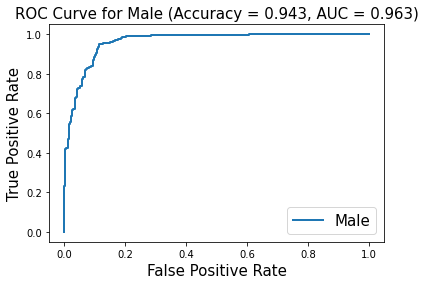

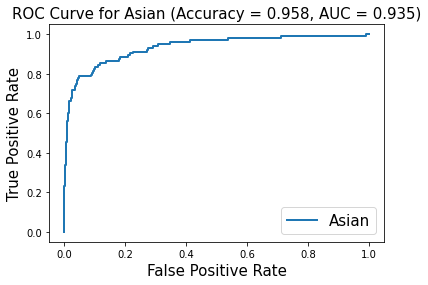

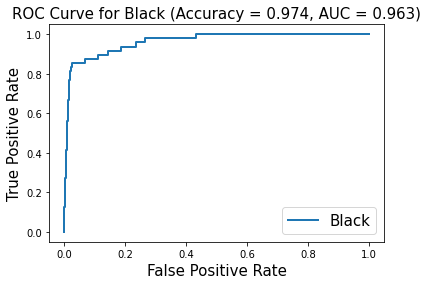

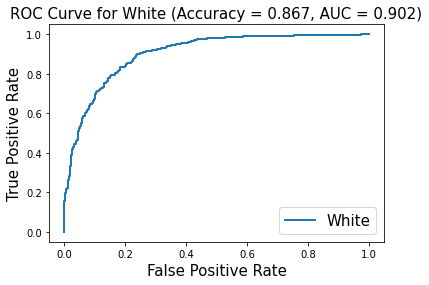

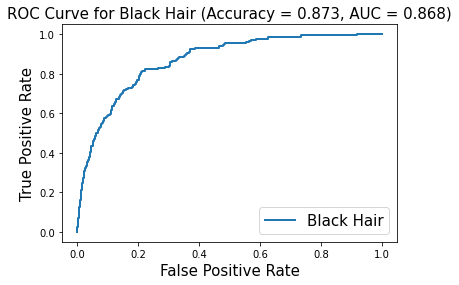

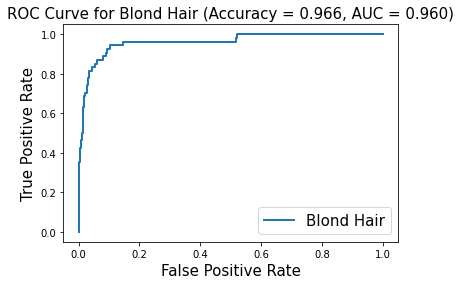

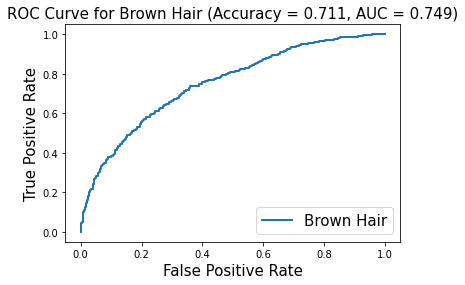

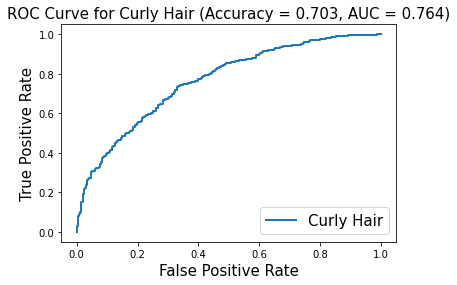

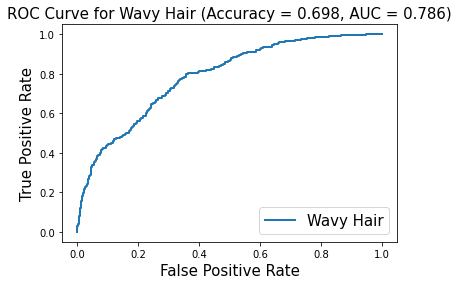

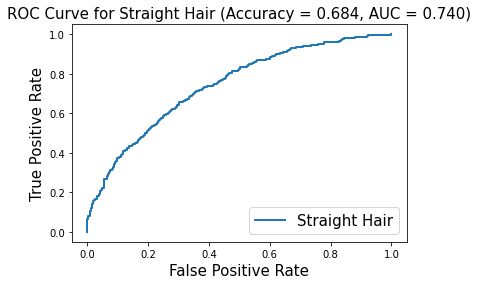

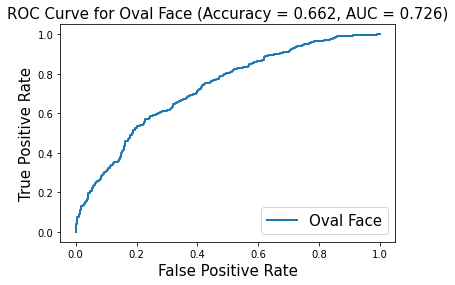

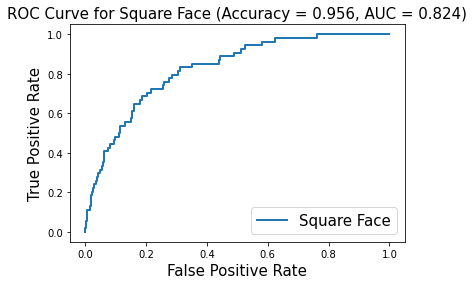

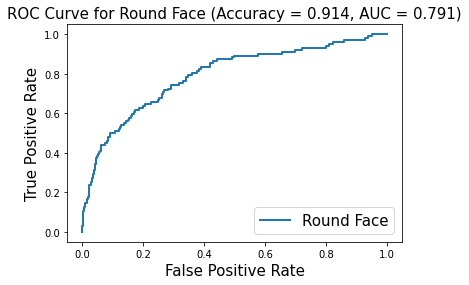

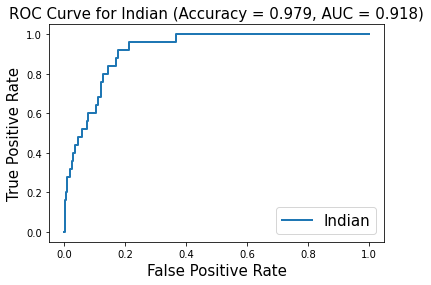

In [112]:
# plot ROC curves
cols = ['Male', 'Asian', 'Black', 'White','Black Hair','Blond Hair','Brown Hair','Curly Hair','Wavy Hair','Straight Hair','Oval Face','Square Face','Round Face','Indian']
for attr in cols:
    target = Y_test[attr]
    score = df_score[attr]
    fig = plot_roc(attr, target, score)